# Projet Info804

_Raphaëlle Huynh / Samy Amarouche_

## 1. Introduction et fondements théoriques

- Explication des concepts fondamentaux de représentation vectorielle des mots
- Histoire et évolution des embeddings de mots
- Principes mathématiques sous-jacents (calcul de probabilités, descente de gradient, etc.)

!!! A Faire

### 2. Préparation des données

- Création d'un pipeline de prétraitement textuel
  - Normalisation (mise en minuscule, suppression des caractères spéciaux)
  - Tokenisation
  - Gestion des mots rares (filtrage par fréquence)
- Construction du vocabulaire et mapping mot-indice
- Génération des paires d'apprentissage (contexte/cible)
- Implémentation de techniques d'échantillonnage négatif et de sous-échantillonnage de mots fréquents

In [2]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/huynh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import numpy as np
from src import TextPreprocessor
from src import CBOWModel
from src import SkipGramModel
from src import generate_skipgram_data
from src import generate_cbow_data
from src import plot_embeddings
from src import ANNClassifier
from src import generate_negative_samples
from src import subsample_frequent_words
from src import *

#### Importation de la base de donnée

In [4]:
import os

def load_text_data(directory):
    """
    Charge tous les fichiers .txt dans un répertoire donné et retourne leur contenu sous forme de liste.
    
    Args:
        directory (str): Chemin vers le répertoire contenant les fichiers .txt.
    
    Returns:
        list: Liste des phrases extraites des fichiers .txt.
    """
    corpus = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='latin1') as file:
                corpus.append(file.read())
    return corpus

# Exemple d'utilisation
directory = "data/archive/"
corpus = load_text_data(directory)
print(f"Nombre de fichiers chargés : {len(corpus)}") # Affiche les 100 premiers caractères du premier fichie
print(f"Exemple de contenu : {corpus[0]}")

Nombre de fichiers chargés : 40
Exemple de contenu : From: mathew <mathew@mantis.co.uk>
Subject: Alt.Atheism FAQ: Atheist Resources

Archive-name: atheism/resources
Alt-atheism-archive-name: resources
Last-modified: 11 December 1992
Version: 1.0

                              Atheist Resources

                      Addresses of Atheist Organizations

                                     USA

FREEDOM FROM RELIGION FOUNDATION

Darwin fish bumper stickers and assorted other atheist paraphernalia are
available from the Freedom From Religion Foundation in the US.

Write to:  FFRF, P.O. Box 750, Madison, WI 53701.
Telephone: (608) 256-8900

EVOLUTION DESIGNS

Evolution Designs sell the "Darwin fish".  It's a fish symbol, like the ones
Christians stick on their cars, but with feet and the word "Darwin" written
inside.  The deluxe moulded 3D plastic fish is $4.95 postpaid in the US.

Write to:  Evolution Designs, 7119 Laurel Canyon #4, North Hollywood,
           CA 91605.

People in the San 

### Création de la pipeline de prétraitement et construction du vocabulaire et mapping mot-indice et Implémentation de techniques d'échantillonnage négatif et de sous-échantillonnage de mots fréquents

In [5]:

tp = TextPreprocessor(min_freq=10)

print(f"Nombre de document avant prétraitement : {len(corpus)}")

corpus = corpus[:int(0.1 * len(corpus))]

print(f"Nombre de document apres prétraitement : {len(corpus)}")

corpus = " ".join(corpus)

tokens = tp.preprocess(corpus)
print(tokens[:10])
tp.build_vocab(tokens)

# Sous-échantillonnage des mots fréquents
subsampled_tokens = subsample_frequent_words(tokens, threshold=1e-4)
print(f"Nombre de tokens après sous-échantillonnage : {len(subsampled_tokens)}")
encoded = tp.encode(subsampled_tokens)

Nombre de document avant prétraitement : 72144038
Nombre de document apres prétraitement : 7214403
['f', 'r', 'h', 'e', 'w', 'h', 'e', 'w', 'n', 'c']
Nombre de tokens après sous-échantillonnage : 5330


### Génération des paires d'apprentissage (contexte/cible)

In [6]:
# Générer les données pour CBOW
X, y = generate_cbow_data(encoded, window=2)

### Implémentation du modèle CBOW (Continuous Bag of Words)

In [6]:
cbow = CBOWModel(
    vocab_size=len(tp.word2idx),
    embedding_dim=100, 
    context_size=4,
    use_ann=True,
    optimizer='adam',
    learning_rate=0.01
)

In [7]:
cbow.summary()
cbow.train(X, y, epochs=100)
cbow_embeddings = cbow.get_embeddings()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 4, 100)         │     1,430,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14300)          │     1,444,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,874,300 (10.96 MB)

 Trainable params: 2,874,300 (10.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 187s 28ms/step - loss: 6.9054
Epoch 2/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 193s 29ms/step - loss: 4.9242
Epoch 3/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 193s 29ms/step - loss: 4.2036
Epoch 4/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 193s 29ms/step - loss: 3.9188
Epoch 5/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 194s 29ms/step - loss: 3.7593
Epoch 6/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 195s 30ms/step - loss: 3.6653
Epoch 7/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 195s 30ms/step - loss: 3.5955
Epoch 8/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 195s 30ms/step - loss: 3.5390
Epoch 9/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 195s 30ms/step - loss: 3.4968
Epoch 10/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 196s 30ms/step - loss: 3.4689
Epoch 11/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 195s 30ms/step - loss: 3.4421
Epoch 12/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 197s 30ms/step - loss: 3.4194
Epoch 13/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 197s 30ms/step - loss: 3.4015
Epoch 14/100
6583/6583 ━━━━━━━━━━━━━━━━━━━━ 197

### Skip-gram

In [5]:
X2 = generate_skipgram_data(encoded, window=2)

In [6]:
skipgram = SkipGramModel(
    vocab_size=len(tp.word2idx),
    embedding_dim=100,
    optimizer='sgd',
    learning_rate=0.01
)

/Volumes/SSD_crucial/Cours/master/info804/projet/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
skipgram.summary()

# Étape 1 : tu génères toutes les paires target/context
positive_pairs = generate_skipgram_data(encoded, window=2)

# Étape 2 : génération des exemples négatifs
negative_samples, labels = generate_negative_samples(len(tp.word2idx), positive_pairs, num_negative=5)

# Étape 3 : décomposer en target/context
target_words, context_words = zip(*negative_samples)
target_words = np.array(target_words, dtype=np.int32)
context_words = np.array(context_words, dtype=np.int32)
labels = np.array(labels, dtype=np.int32)
print(f"target_words.shape: {target_words.shape}")
print(f"context_words.shape: {context_words.shape}")
print(f"labels.shape: {labels.shape}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │  1,430,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,430,000 (5.46 MB)

 Trainable params: 1,430,000 (5.46 MB)

 Non-trainable params: 0 (0.00 B)

target_words.shape: (15170994,)
context_words.shape: (15170994,)
labels.shape: (15170994,)


In [ ]:
# Entraîner le modèle SkipGram avec échantillonnage négatif
skipgram.train(target_words, context_words, labels, epochs=100)

Epoch 1/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 616s 1ms/step - accuracy: 0.5019 - loss: 0.6922
Epoch 2/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 618s 1ms/step - accuracy: 0.5058 - loss: 0.6922
Epoch 3/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 621s 1ms/step - accuracy: 0.5093 - loss: 0.6921
Epoch 4/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 606s 1ms/step - accuracy: 0.5124 - loss: 0.6921
Epoch 5/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 567s 1ms/step - accuracy: 0.5155 - loss: 0.6920
Epoch 6/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 569s 1ms/step - accuracy: 0.5185 - loss: 0.6920
Epoch 7/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 569s 1ms/step - accuracy: 0.5213 - loss: 0.6919
Epoch 8/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 570s 1ms/step - accuracy: 0.5240 - loss: 0.6919
Epoch 9/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 569s 1ms/step - accuracy: 0.5268 - loss: 0.6918
Epoch 10/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 568s 1ms/step - accuracy: 0.5295 - loss: 0.6917
Epoch 11/100
474093/474093 ━━━━━━━━━━━━━━━━━━━━ 5

### Visualisation des embeddings

#### cbow

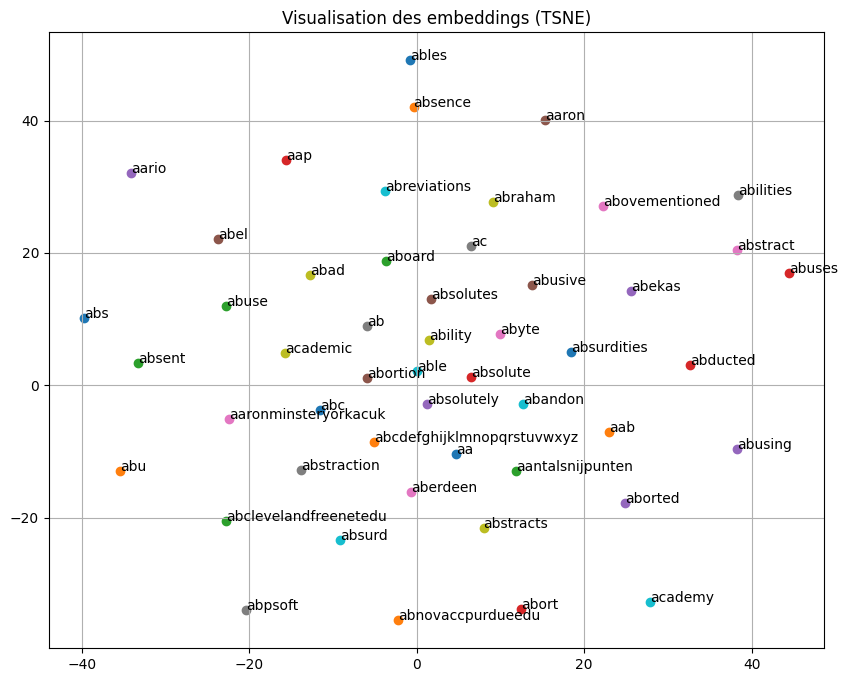

In [16]:
plot_embeddings(cbow_embeddings, tp.idx2word, n_words=50, method='tsne')

#### Skip-gram 

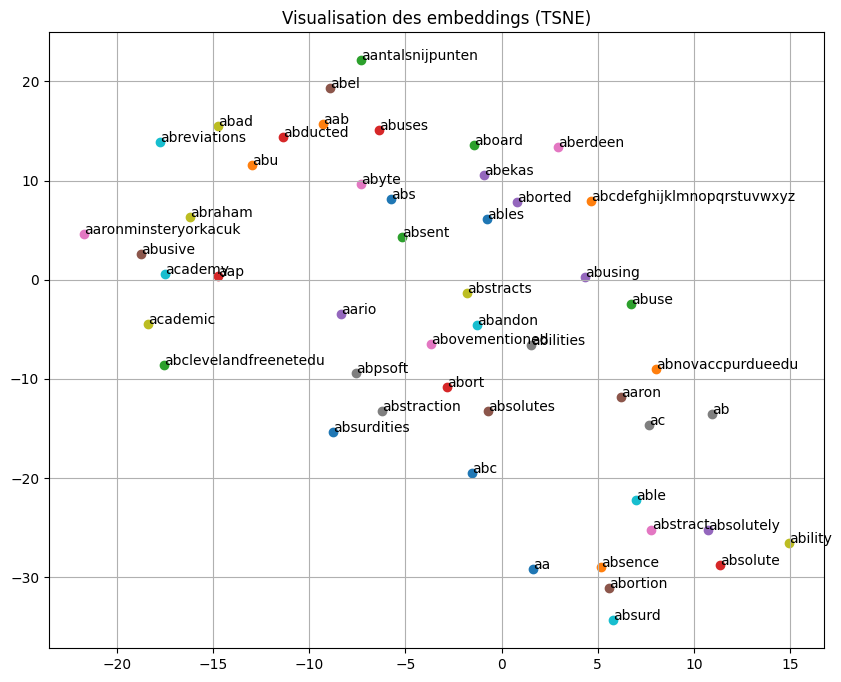

In [15]:
plot_embeddings(skipgram_embeddings, tp.idx2word, n_words=50, method='tsne')

### Évaluation des embeddings

- calcul de la similarité cosinus entre les vecteurs

#### cbow

In [25]:
# Récupère les index
word2idx = tp.word2idx
idx2word = tp.idx2word

cbow_embeddings = np.load("embeddings_cbow_30.npy")
skipgram_embeddings = np.load("embeddings_skipgram_30.npy")

# Exemple de recherche de similarité cosinus
print("Test")
similarite_cosinus("cat", "dog", skipgram_embeddings, word2idx)


Test


np.float32(0.09944435)

### Classification

Importation des données

In [ ]:
import csv

documents = []
labels = []
with open("data/IMDB Dataset.csv", newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # saute l'en-tête
    for row in reader:
        if len(row) != 2:
            continue
        review, label = row
        # Nettoyage : suppression des balises HTML et split en mots
        words = review.replace("<br />", " ").split()
        documents.append(words)
        labels.append(1 if label.lower() == "positive" else 0)
print(f"Nombre de documents : {len(documents)}")
print(f"Exemple de document : {documents[0]}")

import re

def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # supprime les balises HTML
    text = re.sub(r'[^\w\s]', '', text)  # supprime la ponctuation
    return text.lower().split()

words = clean_text(review)

# Exemple de nettoyage
print(f"Exemple de texte nettoyé : {words[:10]}")

Nombre de documents : 50000
Exemple de document : ['one', 'reviewers', 'mentioned', 'watching', '1', 'oz', 'episode', 'hooked.', 'right,', 'exactly', 'happened', 'me.', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence,', 'set', 'right', 'word', 'go.', 'trust', 'me,', 'show', 'faint', 'hearted', 'timid.', 'show', 'pulls', 'punches', 'regards', 'drugs,', 'sex', 'violence.', 'hardcore,', 'classic', 'use', 'word.', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary.', 'focuses', 'mainly', 'emerald', 'city,', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards,', 'privacy', 'high', 'agenda.', 'em', 'city', 'home', 'many..aryans,', 'muslims,', 'gangstas,', 'latinos,', 'christians,', 'italians,', 'irish', 'more....so', 'scuffles,', 'death', 'stares,', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away.', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows'

### Entrainement de mon réseau ANN

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
skipgram_embeddings = np.load("embeddings_cbow_30.npy")
word2idx = tp.word2idx

import csv
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from nltk.corpus import stopwords

# === Prétraitement ===
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # supprime les balises HTML
    text = re.sub(r'[^\w\s]', '', text)  # supprime la ponctuation
    return text.lower().split()

documents = []
labels = []
with open("data/IMDB Dataset.csv", newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # saute l'en-tête
    for row in reader:
        if len(row) != 2:
            continue
        review, label = row
        # Nettoyage : suppression des balises HTML et split en mots
        words = review.replace("<br />", " ").split()
        documents.append(words)
        labels.append(1 if label.lower() == "positive" else 0)
print(f"Nombre de documents : {len(documents)}")
print(f"Exemple de document : {documents[0]}")

classifier = ANNClassifier(embedding_matrix=skipgram_embeddings, word2idx=word2idx, input_length=200)

# Préparation des features
X = classifier.prepare_features(documents)
y = np.array(labels)

# Split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement
classifier.model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédictions & rapport
y_pred = (classifier.model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Nombre de documents : 50000
Exemple de document : ['One', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'Oz', 'episode', "you'll", 'be', 'hooked.', 'They', 'are', 'right,', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me.', 'The', 'first', 'thing', 'that', 'struck', 'me', 'about', 'Oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence,', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'GO.', 'Trust', 'me,', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid.', 'This', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs,', 'sex', 'or', 'violence.', 'Its', 'is', 'hardcore,', 'in', 'the', 'classic', 'use', 'of', 'the', 'word.', 'It', 'is', 'called', 'OZ', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'Oswald', 'Maximum', 'Security', 'State', 'Penitentary.', 'It', 'focuses', 'mainly', 'on', 'Emerald', 'City,', 'an', 'experimental', 'se

### Test avec cbow de gensim

In [5]:
from gensim.models import KeyedVectors

# Charger le modèle Word2Vec de Google (format binaire)
model_path = 'data/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [6]:
import numpy as np

embedding_dim = 300  # Dimensions dans Google Word2Vec
vocab_size = len(tp.word2idx)

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tp.word2idx.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        # Si le mot n’est pas dans Word2Vec, on laisse le vecteur nul (ou on peut le remplir aléatoirement si tu préfères)
        embedding_matrix[i] = np.zeros(embedding_dim)


In [11]:
classifier = ANNClassifier(embedding_matrix=embedding_matrix, word2idx=tp.word2idx)

/Volumes/SSD_crucial/Cours/master/info804/projet/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Préparation des features
X = classifier.prepare_features(documents)
y = np.array(labels)

# Split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Entraînement
classifier.model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Prédictions & rapport
y_pred = (classifier.model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6252 - loss: 0.5938 - val_accuracy: 0.5573 - val_loss: 0.8045
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6247 - loss: 0.5909 - val_accuracy: 0.5559 - val_loss: 0.8058
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6264 - loss: 0.5912 - val_accuracy: 0.5560 - val_loss: 0.8087
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6183 - loss: 0.5927 - val_accuracy: 0.5561 - val_loss: 0.8129
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6269 - loss: 0.5911 - val_accuracy: 0.5569 - val_loss: 0.8150
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6230 - loss: 0.5916 - val_accuracy: 0.5553 - val_loss: 0.8133
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6270 - loss: 0.5927 - val_accuracy: 0.5555 - val_loss: 0.8157
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6204 - loss: 0.5906 - val_accu

In [8]:
import csv
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# === Prétraitement ===
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # supprime les balises HTML
    text = re.sub(r'[^\w\s]', '', text)  # supprime la ponctuation
    return text.lower().split()

documents = []
labels = []
with open("data/IMDB Dataset.csv", newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # saute l'en-tête
    for row in reader:
        if len(row) != 2:
            continue
        review, label = row
        words = clean_text(review)
        documents.append(words)
        labels.append(1 if label.lower() == "positive" else 0)

print(f"Nombre de documents : {len(documents)}")
print(f"Exemple nettoyé : {documents[0][:10]}")

# === Chargement des embeddings Google Word2Vec ===
from gensim.models import KeyedVectors

print("Chargement des embeddings Google...")
model_path = "data/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Construction du vocabulaire et de la matrice d'embedding
embedding_dim = 300
word2idx = {"<PAD>": 0}
embedding_matrix = [np.zeros(embedding_dim)]

for word in word2vec.key_to_index:
    word2idx[word] = len(word2idx)
    embedding_matrix.append(word2vec[word])

embedding_matrix = np.array(embedding_matrix)

# === Entraînement / Test ===
classifier = ANNClassifier(embedding_matrix=embedding_matrix, word2idx=word2idx, input_length=200)

X = classifier.prepare_features(documents)
y = np.array(labels)

# Répartition 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement
classifier.model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédictions
y_pred = (classifier.model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Nombre de documents : 50000
Exemple nettoyé : ['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching']
Chargement des embeddings Google...
Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7443 - loss: 0.5342 - val_accuracy: 0.7799 - val_loss: 0.4516
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8170 - loss: 0.4018 - val_accuracy: 0.8104 - val_loss: 0.4082
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8262 - loss: 0.3870 - val_accuracy: 0.8356 - val_loss: 0.3716
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8257 - loss: 0.3852 - val_accuracy: 0.7953 - val_loss: 0.4440
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8293 - loss: 0.3875 - val_accuracy: 0.8205 - val_loss: 0.3899
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8291 - loss: 0.3855 - val_accuracy: 0.8437 - val_loss: 0.3577
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━

In [1]:
classifier = ANNClassifier(embedding_matrix=embedding_matrix, word2idx=word2idx, input_length=20)

X = classifier.prepare_features(documents)
y = np.array(labels)

# Répartition 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Entraînement
classifier.model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédictions
y_pred = (classifier.model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

NameError: name 'ANNClassifier' is not defined

In [21]:
cbow_embeddings = np.load("embeddings_cbow_30.npy")

classifier = ANNClassifier(embedding_matrix=cbow_embeddings, word2idx=word2idx, input_length=100)

# Répartition 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Entraînement
classifier.model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédictions
y_pred = (classifier.model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_10" is incompatible with the layer: expected axis -1 of input shape to have value 10000, but received input with shape (None, 30000)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 30000), dtype=float32)
  • training=True
  • mask=None

## ANN multiclasse

In [14]:
import os
import glob
import pandas as pd
import numpy as np

# 1. Charger les documents
def load_documents(base_path):
    documents = []
    labels = []
    
    for filepath in glob.glob(os.path.join(base_path, '*'), recursive=False):
        if filepath.endswith('.txt'):
            with open(filepath, 'r', encoding='latin-1') as f:
                text = f.read()
            label = os.path.basename(filepath).replace('.txt', '')  # nom du fichier sans .txt
            documents.append(text)
            labels.append(label)
        elif filepath.endswith('.csv'):
            df = pd.read_csv(filepath)
            for idx, row in df.iterrows():
                text = str(row.values)
                label = os.path.basename(filepath).replace('.csv', '')  # nom du fichier sans .csv
                documents.append(text)
                labels.append(label)
                
    return documents, labels

# Charger les documents
base_path = 'data/archive'
documents_raw, labels_raw = load_documents(base_path)

print(f"Nombre de documents chargés : {len(documents_raw)}")
print(f"Labels trouvés : {sorted(set(labels_raw))}")

# 2. Prétraitement
text_processor = TextPreprocessor(min_freq=5)

# Tokeniser tous les documents
documents_tokenized = [text_processor.preprocess(doc) for doc in documents_raw]

# Construire vocabulaire
all_tokens = [token for tokens in documents_tokenized for token in tokens]
text_processor.build_vocab(all_tokens)

# 3. Encoder les documents
documents_encoded = [text_processor.encode(tokens) for tokens in documents_tokenized]

# 4. Préparer X et y
X = documents_encoded
y_labels = sorted(list(set(labels_raw)))  # toutes les classes distinctes triées
label2idx = {label: idx for idx, label in enumerate(y_labels)}
y = [label2idx[label] for label in labels_raw]

print(f"Nombre de classes : {len(label2idx)}")
print(f"Mapping label -> index : {label2idx}")

# 5. Charger l'embedding
embedding_matrix = np.load("embeddings_cbow_30.npy")

# Instancier ton classifieur
classifier = ANNClassifierMultiClass(
    embedding_matrix, 
    text_processor.word2idx, 
    input_length=100, 
    nb_classes=len(label2idx)
)

# Transformer X
X_ready = classifier.prepare_features(X)

# Entraîner
classifier.train(X_ready, np.array(y), test_size=0.2, epochs=50, batch_size=16, patience=5)


Nombre de documents chargés : 648
Labels trouvés : ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'list', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Nombre de classes : 21
Mapping label -> index : {'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'list': 6, 'misc.forsale': 7, 'rec.autos': 8, 'rec.motorcycles': 9, 'rec.sport.baseball': 10, 'rec.sport.hockey': 11, 'sci.crypt': 12, 'sci.electronics': 13, 'sci.med': 14, 'sci.space': 15, 'soc.religion.christian': 16, 'talk.politics.guns': 17, 'talk.politics.mideast': 18, 'talk.politics.misc': 19, 'talk.religion.misc': 20}
Epoch 1/50
33/33 ━━━━━━

/Volumes/SSD_crucial/Cours/master/info804/projet/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/SSD_crucial/Cours/master/info804/projet/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/SSD_crucial/Cours/master/info804/projet/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 